In [1]:
import numpy as np
import cvxpy as cp
import networkx as nx
import scipy

In [139]:
labels = [
    1,1,1,1,1,1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
]

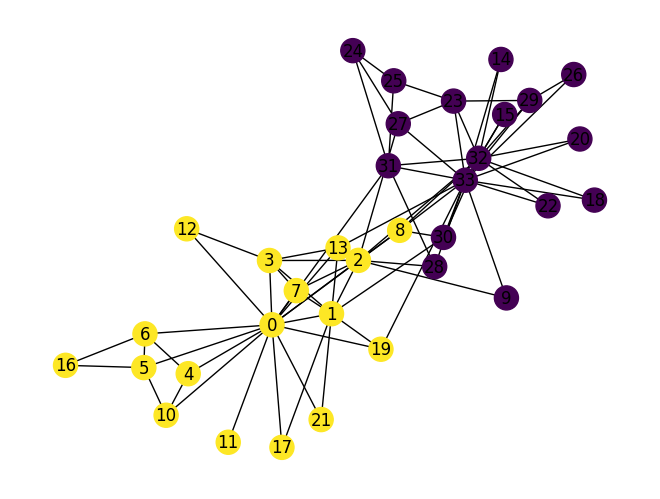

In [140]:
np.random.seed(2)
G = nx.karate_club_graph()
nx.draw(
    G,
    node_color=labels, 
    with_labels=True,
    pos=nx.spring_layout(G)
)

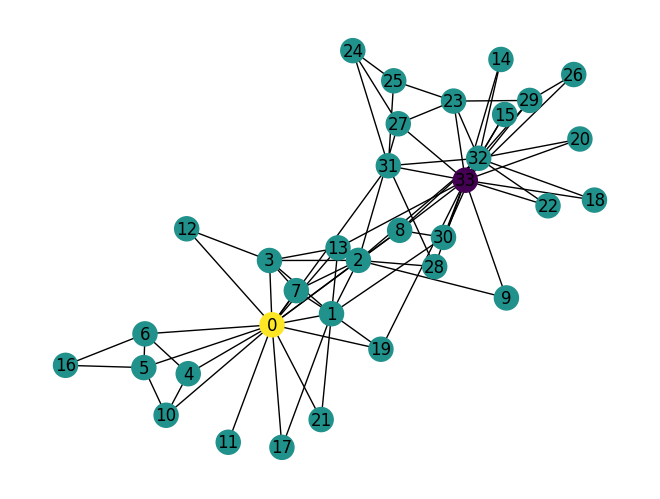

In [194]:
pred_labels = labels.copy()
for i in range(1, 33):
    pred_labels[i] = 0
np.random.seed(2)
G = nx.karate_club_graph()
nx.draw(
    G,
    node_color=pred_labels, 
    with_labels=True,
    pos=nx.spring_layout(G)
)

In [307]:
n = len(G)
laplacian = nx.normalized_laplacian_matrix(G).toarray()
heat_kernel = scipy.linalg.expm(-3*laplacian)
heat_kernel[0]

array([0.19374388, 0.1143917 , 0.09882284, 0.09194119, 0.08665405,
       0.09704713, 0.09431967, 0.07494824, 0.04693909, 0.01251971,
       0.08274566, 0.07009364, 0.0483166 , 0.07860059, 0.00656453,
       0.00808233, 0.05513018, 0.05729592, 0.00540572, 0.05406557,
       0.0056631 , 0.05877087, 0.0068752 , 0.01231364, 0.01019445,
       0.01505248, 0.0045751 , 0.01597066, 0.02000107, 0.0072716 ,
       0.02551391, 0.03113185, 0.02452076, 0.03384065])

In [339]:
train_samples = [0, 1, 33]
X = heat_kernel[train_samples, :][:, train_samples]
node_label_dict = {i: labels[i] for i in train_samples}
y = np.array(list(node_label_dict.values()))
n = len(train_samples)

In [343]:
list(node_label_dict.keys())

[0, 1, 33]

In [345]:
D = cp.psd_wrap(X.copy() * np.outer(y, y))
alpha = cp.Variable(n)
constraints = [alpha.T @ y == 0, alpha >= 0]
print(D)
lagrangian = -(1/2)*cp.quad_form(alpha, D) + cp.sum(alpha)
prob = cp.Problem(cp.Maximize(lagrangian), constraints)
prob.solve()

print("\nThe optimal value is", prob.value)
print("A solution x is")
print(alpha.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)

psd_wrap([[0.19 0.11 -0.03]
 [0.11 0.16 -0.04]
 [-0.03 -0.04 0.20]])

The optimal value is 7.358672938549317
A solution x is
[2.64630917 4.71236377 7.35867294]
A dual solution corresponding to the inequality constraints is
0.1972608113178115


In [324]:
W = np.array([y[i] * alpha.value[i] * X[i] for i in range(n)])

In [325]:
(y * alpha.value)

array([ 2.64630917,  4.71236377, -7.35867294])

In [326]:
y = np.array(y)

In [327]:
b = (y - heat_kernel[train_samples, :][:, train_samples] @ (y * alpha.value))[0]
b

np.float64(0.1972608113178116)

In [329]:
pred_y = heat_kernel[:][:, train_samples] @ (y * alpha.value) + b
pred_y

array([ 1.        ,  1.        ,  0.56279969,  0.75062432,  0.50233484,
        0.52946552,  0.52139073,  0.71018427, -0.03809372, -0.05848384,
        0.48353957,  0.46120046,  0.45924512,  0.53323959, -0.20000694,
       -0.33240491,  0.3776123 ,  0.50206844, -0.17116754,  0.41844831,
       -0.11863651,  0.57281748, -0.25878535, -0.4424631 , -0.06707761,
       -0.17700092, -0.23658055, -0.25027407, -0.02781094, -0.37371968,
       -0.06884365, -0.26120665, -0.67143537, -1.        ])

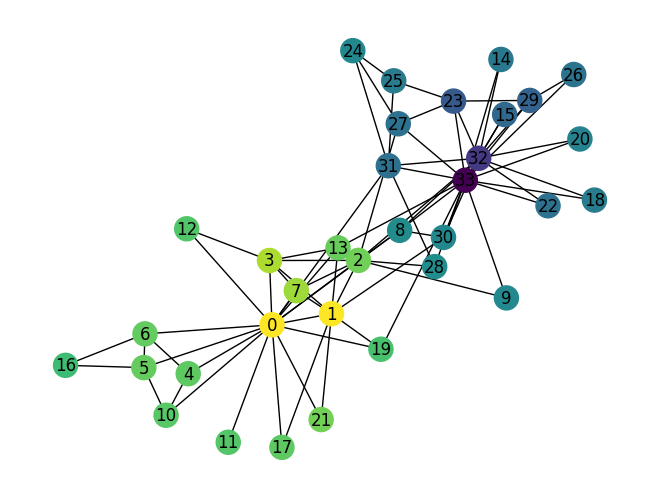

In [330]:
np.random.seed(2)
G = nx.karate_club_graph()
nx.draw(
    G,
    node_color=pred_y, 
    with_labels=True,
    pos=nx.spring_layout(G)
)

In [352]:
np.sum(np.sign(pred_y) == labels)

np.int64(33)